# Finding Heavy Traffic Indicators on I-94

This project's goal is to find indicators of heavy traffic on I-94 using features observed in a data set collected from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume#). It has a dataset description as below:
> Hourly Interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume.

With a data dictionary:

| Column | Type | Description |
| :---- | :----: | :--- |
| holiday | Categorical | US National holidays plus regional holiday, Minnesota State Fair |
| temp | Numeric | Average temp in kelvin |
| rain_1h | Numeric | Amount in mm of rain that occurred in the hour
| snow_1h | Numeric | Amount in mm of snow that occurred in the hour |
| clouds_all | Numeric | Percentage of cloud cover |
| weather_main | Categorical | Short textual description of the current weather |
| weather_description | Categorical | Longer textual description of the current weather |
| date_time | DateTime | Hour of the data collected in local CST time |
| traffic_volume | Numeric | Hourly I-94 ATR 301 reported westbound traffic volume |

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

traffic = pd.read_csv('./I-94 Traffic Data 2012 - 2018/Metro_Interstate_Traffic_Volume.csv')

In [2]:
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 2.6+ MB


## Initial Exploration

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

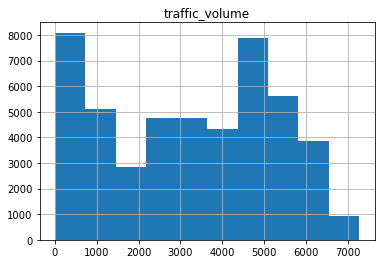

In [5]:
%matplotlib inline

traffic.hist('traffic_volume')
traffic['traffic_volume'].describe()

There aren't any null values which means we have the complete collected conditions for each entry and there is no need to delete rows or estimate values. Measurements start on 2012-10-02 at 9 AM until 2018-09-30 at 11 PM. Which means there should be 6 years, minus 2 days, plus a leap year day, minus 1 hour worth of hours if the data was recorded 24/7/365.

In [6]:
(((6 * 365) - 1) * 24 - 1)

52535

In [7]:
len(traffic) / (((6 * 365) - 1) * 24 - 1) * 100

91.75597220900352

First, the totals hours collected does not match a 6 year-24/7 schedule. There are some gaps in data collection whether on purpose or accident. These gaps are about 9% of the total possible time. This is significant enough to introduce bias, but as long as they are somewhat random and not consistent then it may have an insignificant effect on the patterns we see.

Around 25% of the time, there were less than 1,200 cars passing the station each hour. Another 25% of the time, there were over about 5,000 cars passing by.

A possible explanation for this U-shaped histogram are the cycles of traffic during the day and night. I will separate daytime and nighttime data to confirm that nighttime has lighter traffic and will not help indicate heavy traffic.

## Time Indicators

### Day vs. Night

For consistency I will define day as:
7 a.m. to 7 p.m. (12 hours)
and night as:
7 p.m. to 7 a.m. (12 hours)

I can adjust these hours if it seems to not suit the data, then they would not be called cycles of day and night, but as cycles of something else such as daily work schedules.

In [8]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])
traffic['date_time']

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

In [9]:
hours = traffic['date_time'].dt.hour
daytime = traffic[(hours >= 7) & (hours < 19)].reset_index()
nighttime = traffic[(hours >= 19) | (hours < 7)].reset_index()

In [10]:
gaps = pd.Series([], dtype='int64')
for i in range(len(hours) - 1):
    if hours[i]:
        if (hours[i+1] + 1) - (hours[i] + 1) > 1:
            gaps[i] = hours[i]

In [11]:
gaps.describe()

count    2293.000000
mean       10.973833
std         5.911226
min         1.000000
25%         6.000000
50%        11.000000
75%        16.000000
max        21.000000
dtype: float64

There are 2293 instances of missing hours. I have recorded when the gap begins and some gaps are longer than 2 hours. This may account for the non 24/7/365 behavior. For now there I will continue without these values and estimate their influence in the **Next Steps**.

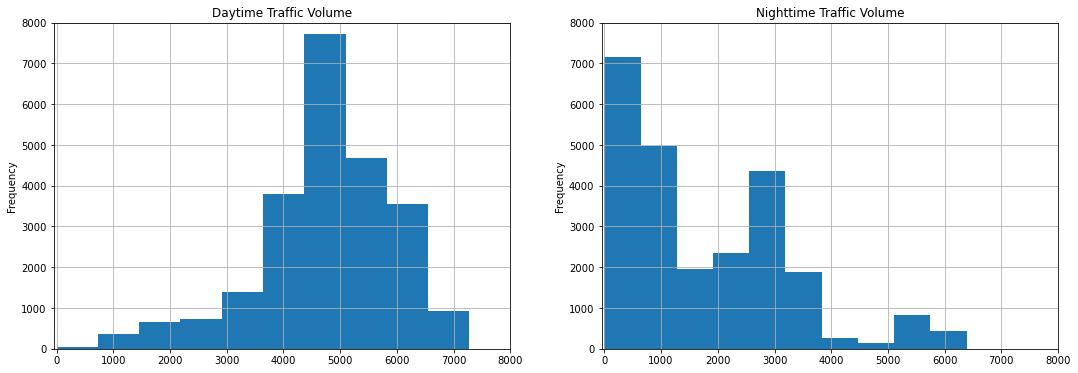

In [12]:
plt.figure('DayvNight', figsize=(18,6))
plt.subplot(1,2,1)
daytime['traffic_volume'].plot.hist(title='Daytime Traffic Volume',
                                    grid=True,
                                    xlabel='Number of Cars',
                                    ylabel='Frequency',
                                    xlim=(-50,8000),
                                    ylim=(0,8000))

plt.subplot(1,2,2)
nighttime['traffic_volume'].plot.hist(title='Nighttime Traffic Volume',
                                      grid=True,
                                      xlabel='Number of Cars',
                                      ylabel='Frequency',
                                      xlim=(-50,8000),
                                      ylim=(0,8000))

In [13]:
display(daytime['traffic_volume'].describe())
display(nighttime['traffic_volume'].describe())

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

Daytime volume has a left skew with a mean of 4,762. Nighttime volume has a split right skew. There are two peaks, the first and highest peak of around 200 cars forms a tail as it reaches the second peak of around 2,900 cars which then forms a meager tail. Although the nighttime data has some entries of high volume, we can confidently say that for a majority of the time we consider "night" has a low volume. Since I am trying to detect what causes or influences heavy traffic, I will investigate the high volumes within the nighttime data and remove the rest.

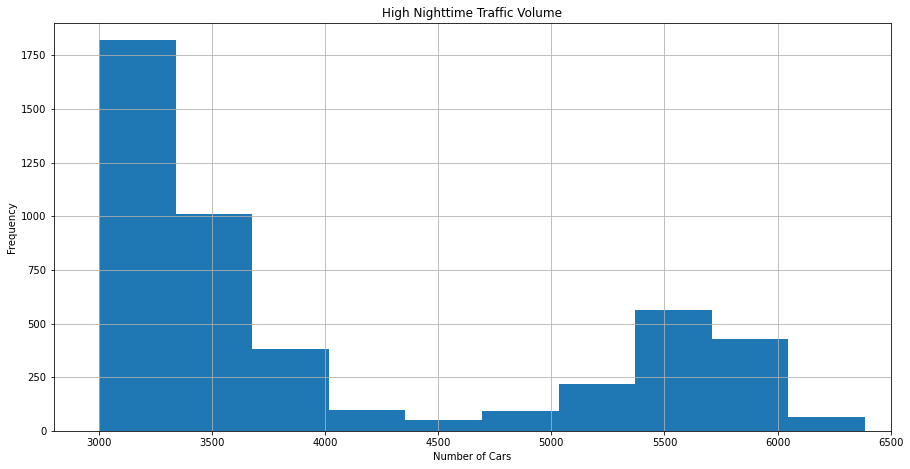

In [14]:
high_vol_nighttime = nighttime[nighttime['traffic_volume'] >= 3000]

plt.figure('highvolnight', figsize=(15,7.5))
(high_vol_nighttime['traffic_volume']
 .plot.hist(title='High Nighttime Traffic Volume',
            grid=True,
            xlim=(2800, 6500),
            ylim=(0, 1900)
           )
)
plt.xlabel('Number of Cars')
plt.ylabel('Frequency')
plt.show()

Daytime volumes start to grow rapdily in frequency at 3,000 cars. Nighttime volume does not have as many hours with this many cars, in fact I have a prediction that the hours with these amount of cars are actually just outside of our predetermined range of nighttime and daytime. Extending our range of hours considered daytime may give a more accurate insight to heavy traffic.

In [15]:
high_vol_nighttime['date_time'].dt.hour.value_counts()

19    1548
6     1446
20     719
21     483
22     269
5      207
23      50
0        4
Name: date_time, dtype: int64

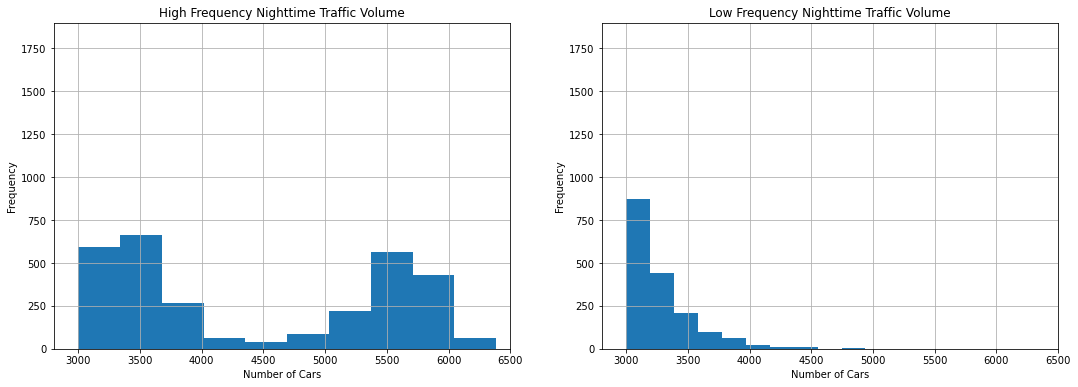

In [16]:
plt.figure('freqnighttime', figsize=(18,6))
plt.subplot(1,2,1)
(high_vol_nighttime.query('date_time.dt.hour in (6,19)')['traffic_volume']
 .plot.hist(title='High Frequency Nighttime Traffic Volume',
            grid=True,
            xlim=(2800, 6500),
            ylim=(0, 1900)
           )
)
plt.xlabel('Number of Cars')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
(high_vol_nighttime.query('date_time.dt.hour not in (6,19)')['traffic_volume']
 .plot.hist(title='Low Frequency Nighttime Traffic Volume',
            grid=True,
            xlabel='Number of Cars',
            ylabel='Frequency',
            xlim=(2800, 6500),
            ylim=(0, 1900)
           )
)
plt.xlabel('Number of Cars')
plt.ylabel('Frequency')

plt.show()

The hours with more than 3,000 cars in the nighttime data range from 7 PM - 12 AM and 5 AM - 6 AM. The times that have the highest frequencies are 6 AM and 7 PM, which matches my prediction. I can add in 6 AM, and 7 PM to the daytime range to increase the accuracy of our indicators for heavy traffic.

In [17]:
daytime = traffic[(hours >= 6) & (hours <= 19)].reset_index()

### Wider Periods of Time

I will now use the modified daytime data as my new focus, since nighttime does not have as much high volume entries and will skew some of our averages. Other than throughout the day and night, traffic can vary by days of the week, months and years. I will explore some plots of time of day, days of the week, and months, ignoring years since I do not have enough data for such a large scale.

### Months

In [18]:
daytime.loc[:, 'month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
by_month['traffic_volume']

month
1     4354.506274
2     4561.668150
3     4697.060550
4     4733.964271
5     4754.816176
6     4750.101802
7     4466.139009
8     4782.513801
9     4719.379909
10    4784.037931
11    4552.144880
12    4227.925219
Name: traffic_volume, dtype: float64

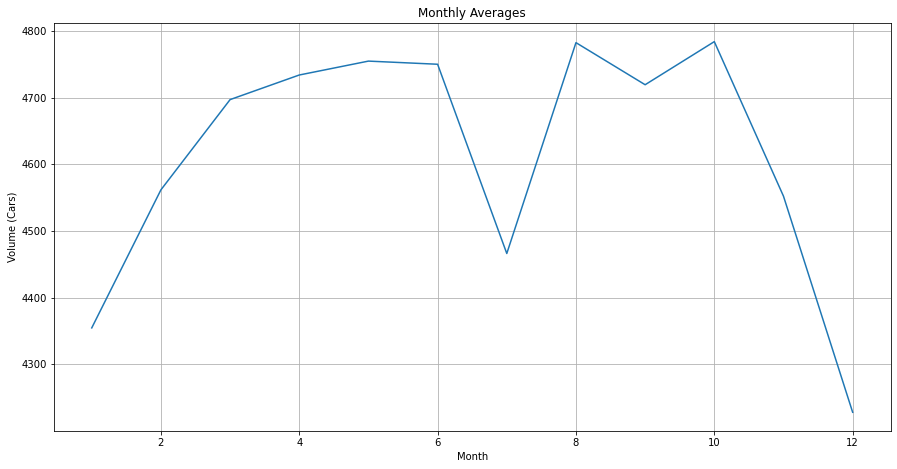

In [19]:
plt.figure('monthlyaverage', figsize=(15,7.5))
(by_month['traffic_volume']
 .plot(title='Monthly Averages',
       grid=True,
       xlabel='Month',
       ylabel='Volume (Cars)'
      )
)

Traffic increases in the beginning of the year plateauing in the summer months. There is a strange, steep decline in June of about 300 cars. This does not seem like much, but relatively these volumes are low. This dip could have been a string of missed hours or some other factors. Ignoring month 7, the months from 5-10 (May to October) have consistent volumes which can correlate to the summer where many people will take time off work and students will have a summer break, so there will be more cars going places. However, what is interesting is that average volumes are not high during the winter months. In fact, they are the lowest of the set. Perhaps, many people do not want to be out in the cold and prefer to stay home where it is warm.

### Day of the Week

In [20]:
daytime.loc[:, 'dayofweek'] = daytime['date_time'].dt.dayofweek
by_dow = daytime.groupby('dayofweek').mean()
by_dow['traffic_volume']

dayofweek
0    4771.066360
1    5071.712720
2    5171.716737
3    5187.552885
4    5164.136903
5    3697.681496
6    3213.063237
Name: traffic_volume, dtype: float64

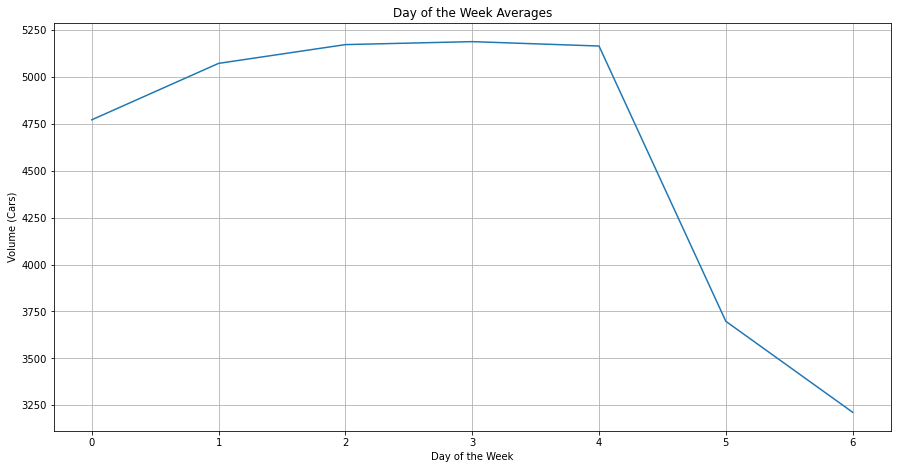

In [21]:
plt.figure('dowaverage', figsize=(15,7.5))
(by_dow['traffic_volume']
 .plot(title='Day of the Week Averages',
       grid=True,
       xlabel='Day of the Week',
       ylabel='Volume (Cars)'
      )
)

plt.show()

The high volumes span from Monday to Friday. There are comparatively low volumes from Saturday to Sunday. The most common work schedule in the USA is 9 AM to 5 PM, Monday to Friday. This aligns with the data since the most people will be driving during the week, and less during the weekends.

In [22]:
daytime.loc[:, 'hour'] = daytime['date_time'].dt.hour
business_days = daytime.loc[daytime['dayofweek'] <= 4]
weekend_days = daytime.loc[daytime['dayofweek'] >= 5]

In [23]:
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend = weekend_days.groupby('hour').mean()

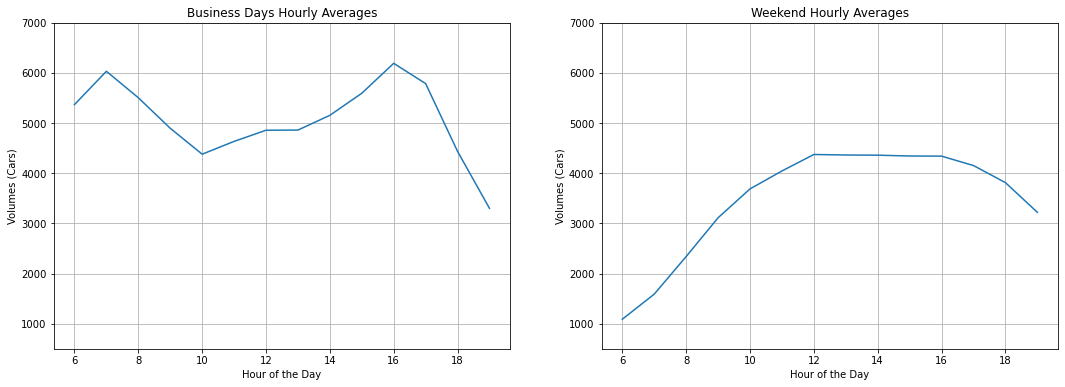

In [24]:
plt.figure('byhourbusinessvweekend', figsize=(18,6))
plt.subplot(1,2,1)
(by_hour_business['traffic_volume']
 .plot(title='Business Days Hourly Averages',
       grid=True,
       xlabel='Hour of the Day',
       ylabel='Volumes (Cars)',
       ylim=(500, 7000)
      )
)

plt.subplot(1,2,2)
(by_hour_weekend['traffic_volume']
 .plot(title='Weekend Hourly Averages',
       grid=True,
       xlabel='Hour of the Day',
       ylabel='Volumes (Cars)',
       ylim=(500, 7000)
      )
)

plt.show()

Business day averages are distinctly higher than weekeend averages. At a given hour on a business day there will be more cars on I-94 than at the same hour on a weekend. This is most likely due to the work schedule that has been made a standard for businesses. I can even recognize the rush hours, from 6 - 8 AM and 3 - 5 PM. On the weekends, people like to sleep in or plan activities in the afternoon and not too late into the evening, so they can take advantage of the sunlight.

### Time Indicator Conclusions

From the most significant observable time scale of our data set, daytime, specifically 6 AM - 7 PM, has the highest traffic volume compared to nighttime. Next, the middle months, April (4) - October (10), hold a plateau of the highest traffic volume on average within the years of the dataset. Further, weekdays, Monday - Friday, are much busier than weekends. On a weekday, there are peaks of traffic during rush hour of starting work and leaving work. During the weekend traffic is not as heavy, but plateaus in the afternoon and slowly drops in the evening. 

## Weather Indicators

I went over time indicators, next are weather indicators.
- temp
- rain_1h
- snow_1h
- clouds_all
- weather_main
- weather_description

### Numerical Weather Indicators

First, I will find the indicator with the highest correlation to `traffic_volume` and the most relevant to the scope of this investigation.

In [25]:
weather_traffic_corr = daytime.corr()['traffic_volume']
weather_traffic_corr.sort_values(ascending=False)

traffic_volume    1.000000
temp              0.117139
hour              0.040569
snow_1h           0.003786
rain_1h           0.003612
index             0.002734
month            -0.016202
clouds_all       -0.024714
dayofweek        -0.407851
Name: traffic_volume, dtype: float64

`temp` seems like the only weather indicator with a high correlation to `traffic_volume`.

<Figure size 1080x540 with 0 Axes>

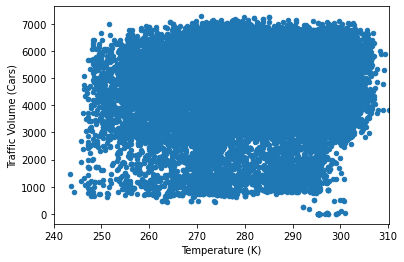

In [26]:
plt.figure('tempvvolumescatter', figsize=(15,7.5))
(daytime.plot
 .scatter('temp', 'traffic_volume',
          xlabel='Temperature (K)',
          ylabel='Traffic Volume (Cars)',
          xlim=(240, max(daytime.loc[:,'temp']))
         )
)
plt.show()

As expected, `temp` is not particularly helpful. Although the spread suggests that higher temperatures lead to more traffic, there is not a strong enough correlation to conclusive state that temperature is a strong indication of high traffic volume. Perhaps, the categorical weather indicators will be more informative.

### Categorical Weather Indicators

I will start by observing the average traffic volume associated with each unique label in `weather_main` and `weather_description`

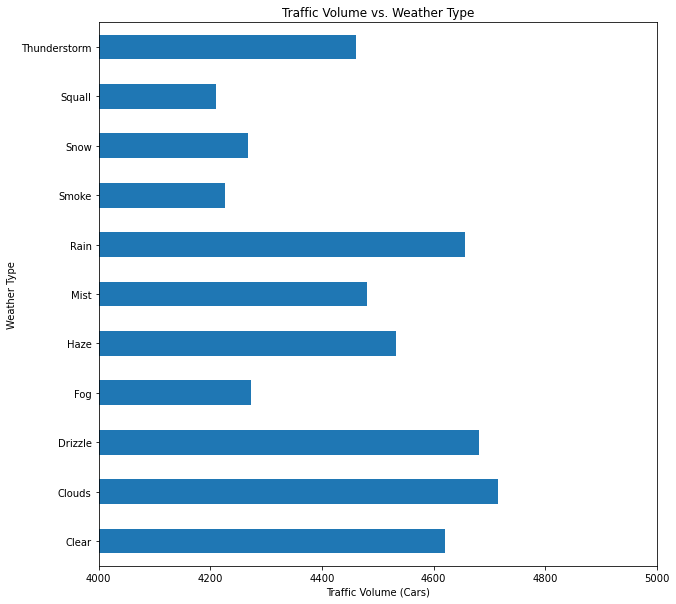

In [27]:
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_description = daytime.groupby('weather_description').mean()

(by_weather_main['traffic_volume'].plot
 .barh(title='Traffic Volume vs. Weather Type',
       figsize=(10,10),
       xlim=(4000, 5000)
      )
)
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Weather Type')
plt.show()

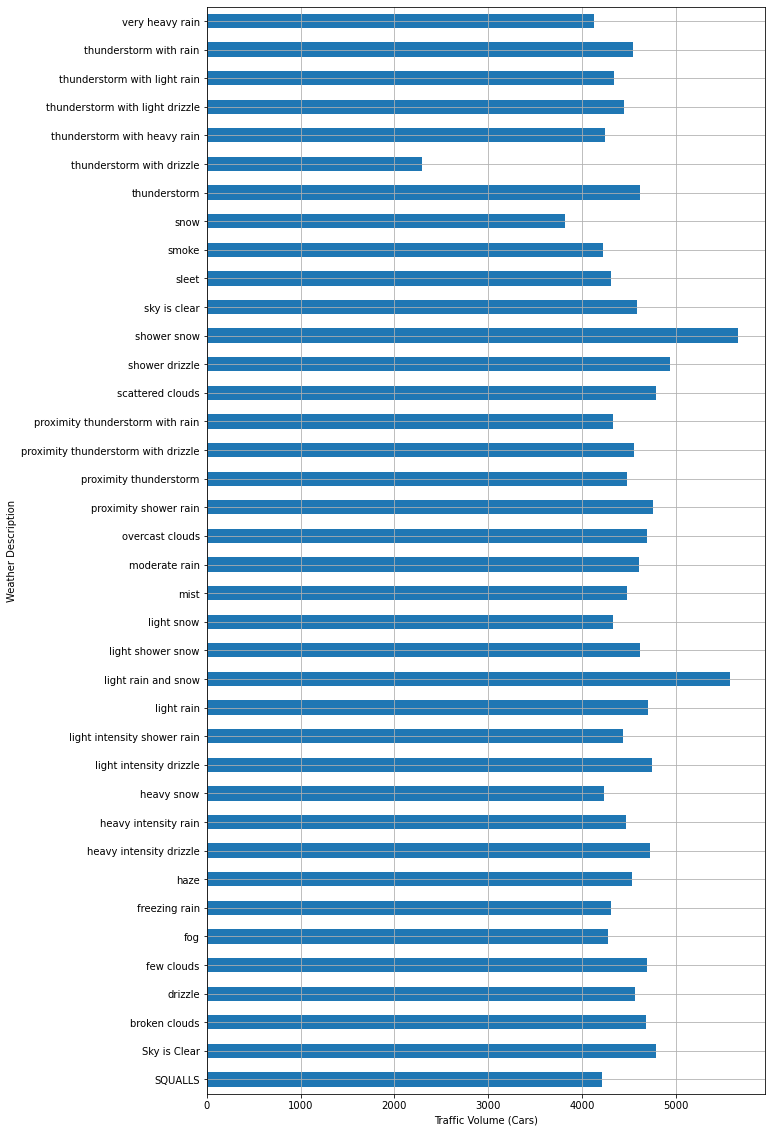

In [28]:
(by_weather_description['traffic_volume'].plot
 .barh(figsize=(10,20),
       grid=True
      )
)
plt.xlabel('Traffic Volume (Cars)')
plt.ylabel('Weather Description')
plt.show()

`weather_main` was not especially helpful. Every type within the column has an average of over 4000, but less than 5000 cars. However, "Rain", "Drizzle", "Clouds", and "Clear" were the top 4 averages. In `weather_description`, I could extract some more differences between each weather type. There were 2 descriptions that stood out in this column, "shower snow" and "light rain and snow". These two have a high correlation to heavier traffic, since the other descriptions generally stay within the same range of traffic volume.

# Conclusion

### Time indicators
- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to the weekends.
- On business days, the rush hours are around 7 and 16.


### Weather indicators
- Shower snow
- Light rain and snow

## Next steps

- Use the nighttime data to look for heavy traffic indicators.
- Find more time and weather indicators.